In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline


In [2]:
import sys
sys.path.append('/home/courtney/voxelmorph/src')
import os
import glob
import sys
import random
from argparse import ArgumentParser
import time
import pickle

# third-party imports
import tensorflow as tf
import numpy as np
from keras.backend.tensorflow_backend import set_session
from keras.optimizers import Adam
from keras.models import load_model, Model
from keras.losses import mean_squared_error
import keras.backend as K
from neuron.plot import slices
import scipy.io as sio
from scipy.interpolate import interpn
import matplotlib.pyplot as plt
import nibabel as nib


# project imports
sys.path.append('../ext/medipy-lib')
import medipy
import networks
from medipy.metrics import dice
import datagenerators
import losses
from restrict import restrict_GPU_tf, restrict_GPU_keras

Using TensorFlow backend.


In [3]:
def restrict_GPU_tf(gpuid, memfrac=0, use_cpu=False):
    """
        gpuid: str, comma separated list "0" or "0,1" or even "0,1,3"
        memfrac: float, fraction of memory. By default grows dynamically
    """
    if not use_cpu:
        os.environ["CUDA_VISIBLE_DEVICES"] = gpuid

        config = tf.ConfigProto()
        if memfrac == 0:
            config.gpu_options.allow_growth = True
        else:
            config.gpu_options.per_process_gpu_memory_fraction = memfrac
        tf.Session(config=config)
        print("Using GPU:{} with {:.0f}% of the memory".format(gpuid, memfrac*100))
    else:
        os.environ["CUDA_VISIBLE_DEVICES"] = ""
        print("Using CPU")

In [4]:
# Keras 
def restrict_GPU_keras(gpuid, memfrac=0, use_cpu=False):
    """
        gpuid: str, comma separated list "0" or "0,1" or even "0,1,3"
        memfrac: float, fraction of memory. By default grows dynamically
    """
    if not use_cpu:
        os.environ["CUDA_VISIBLE_DEVICES"] = gpuid

        config = tf.ConfigProto()
        if memfrac == 0:
            config.gpu_options.allow_growth = True
        else:
            config.gpu_options.per_process_gpu_memory_fraction = memfrac
        set_session(tf.Session(config=config))
        print("Using GPU:{} with {:.0f}% of the memory".format(gpuid, memfrac*100))
    else:
        os.environ["CUDA_VISIBLE_DEVICES"] = ""
        print("Using CPU")

In [5]:
num_bins = 45
bin_centers = np.linspace(0, 0.7, num_bins*2+1)[1::2]
vol_bin_centers = bin_centers
sigma_ratio = 0.5
sigma = np.mean(np.diff(bin_centers))*sigma_ratio
preterm = 1 / (2 * np.square(sigma))

def mi_test(y_true, y_pred):
    """ soft mutual info """
    y_pred = np.clip(y_pred, 0, 0.7)
    y_true = np.clip(y_true, 0, 0.7)

    # reshape: flatten images into shape (batch_size, heightxwidthxdepthxchan, 1)
    y_true = np.reshape(y_true, (-1, np.prod(np.shape(y_true)[1:])))
    y_true = np.expand_dims(y_true, 2)
    y_pred = np.reshape(y_pred, (-1, np.prod(np.shape(y_pred)[1:])))
    y_pred = np.expand_dims(y_pred, 2)

    nb_voxels = np.shape(y_pred)[1]

    # reshape bin centers to be (1, 1, B)
    o = [1, 1, np.prod(vol_bin_centers.shape)]
    vbc = np.reshape(vol_bin_centers, o)

    # compute image terms
    I_a = np.exp(- preterm * np.square(y_true  - vbc))
    I_a /= np.sum(I_a, -1, keepdims=True)
    print('I_a max', np.max(I_a))

    I_b = np.exp(- preterm * np.square(y_pred  - vbc))
    I_b /= np.sum(I_b, -1, keepdims=True)
    print('I_b max', np.max(I_b))

    # compute probabilities
    I_a_permute = np.transpose(I_a, (0,2,1))
    pab = np.dot(I_a_permute[0,:,:], I_b[0,:,:])  # should be the right size now, nb_labels x nb_bins
    pab /= nb_voxels

#     print(pab_val[0,:,:])
#     print(np.max(pab_val[0,:,:]))

    pa = np.mean(I_a, axis=1, keepdims=True)
    pb = np.mean(I_b, axis=1, keepdims=True)
    epsilon = 10**(-7)
    papb = np.dot(np.transpose(pa, (0,2,1))[0,:,:], pb[0,:,:]) + epsilon
    mi = np.sum(pab * np.log(pab/papb + epsilon))

#     print('mi', mi)
#     slices([pab[1:,1:]])
    return mi, pab

In [10]:
def create_graph(model_name, iter_num, step_size, gpu_id, n_test, invert_images=False, test_mi=False, max_clip=0.7):    
    test_brain_file = open('../src/val_files.txt')
    test_brain_strings = test_brain_file.readlines()
    test_brain_strings = [x.strip() for x in test_brain_strings]
    n_batches = len(test_brain_strings)
    good_labels = sio.loadmat('../data/labels.mat')['labels'][0]
    
    # setup
    gpu = '/gpu:' + str(gpu_id)
    #     print(gpu)
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

    restrict_GPU_tf(str(gpu_id))
    restrict_GPU_keras(str(gpu_id))

    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    config.allow_soft_placement = True
    set_session(tf.Session(config=config))

    vol_size=(160,192,224)
    nf_enc=[16,32,32,32]
    nf_dec=[32,32,32,32,32,16,16]
    
    atlas_vol = nib.load('../data/t2_atlas_027_S_2219.nii').get_data()[np.newaxis,...,np.newaxis]
    atlas_seg = nib.load('../data/t2_atlas_seg_027_S_2219.nii').get_data()
    
    atlas_vol = atlas_vol/np.max(atlas_vol) * max_clip

    images = []
    for step in range(0, n_test):
        vol_name, seg_name = test_brain_strings[step].split(",")
        X_vol, X_seg = datagenerators.load_example_by_name(vol_name, seg_name)
        images.append([X_vol, X_seg])

    sz = atlas_seg.shape
    z_inp1 = tf.placeholder(tf.float32, sz)
    z_inp2 = tf.placeholder(tf.float32, sz)
    z_out = losses.kdice(z_inp1, z_inp2, good_labels)
    kdice_fn = K.function([z_inp1, z_inp2], [z_out])

    nn_trf_model = networks.nn_trf(vol_size)
    
    dices = []
    mis = []
    
    for i in range(iter_num//step_size + 1):
        print(i)
        start_time = time.time()

        # load weights of model
        with tf.device(gpu):
            net = networks.cvpr2018_net(vol_size, nf_enc, nf_dec)
            net.load_weights('../models/' + model_name +
                             '/' + str(i*step_size) + '.h5')

        print('model loaded', time.time()-start_time)
        dice_means = []
        mi_means = []

        for step in range(0, n_test):
            X_vol, X_seg = images[step]
            if invert_images:
                X_vol = max_clip - X_vol

            with tf.device(gpu):
                pred = net.predict([X_vol, atlas_vol])
                warp_seg = nn_trf_model.predict([X_seg, pred[1]])
                mean = np.mean(kdice_fn([warp_seg[0,:,:,:,0], atlas_seg]))
                dice_means.append(mean)
                if test_mi:
                    mi_val, _ = mi_test(atlas_vol, pred[0])
                    print(mi_val)
                    mi_means.append(mi_val)

        print('tested patients', time.time()-start_time)
        dices.append(np.mean(dice_means))
        if test_mi:
            mis.append(np.mean(mi_means))
    if test_mi:
        return dices, mis
    else:
        return dices

In [11]:
model_name = 'mi_t2l_p12b36l2s05_2'
num_iters = 98000
step_size = 2000
gpu_id = 3
n_test = 10
dices = create_graph(model_name, num_iters, step_size, gpu_id, n_test)

Using GPU:3 with 0% of the memory
Using GPU:3 with 0% of the memory
0
model loaded 1.018585443496704
tested patients 20.116419076919556
1
model loaded 0.9457032680511475
tested patients 11.394084930419922
2
model loaded 1.177584171295166
tested patients 11.615639209747314
3
model loaded 1.074568510055542
tested patients 11.902056217193604
4
model loaded 1.3680851459503174
tested patients 11.41967487335205
5
model loaded 1.2222411632537842
tested patients 11.709664821624756
6
model loaded 1.3054542541503906
tested patients 12.672562837600708
7
model loaded 1.5917975902557373
tested patients 12.745151042938232
8
model loaded 1.440894603729248
tested patients 14.313300609588623
9
model loaded 1.5367119312286377
tested patients 12.94681191444397
10
model loaded 1.8253145217895508
tested patients 14.702363967895508
11
model loaded 1.6331970691680908
tested patients 12.970191240310669
12
model loaded 1.6598389148712158
tested patients 12.892885446548462
13
model loaded 1.710569143295288
test

In [12]:
file = open('../models/%s/%s.txt' % (model_name, model_name),'wb') 
pickle.dump([num_iters, step_size, dices], file)
file.close()

mi_t2l_p12b36l2s05_2


/afs/csail.mit.edu/u/c/courtney/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


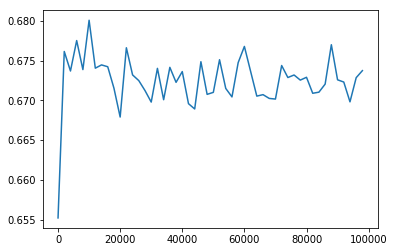

In [13]:
print(model_name)
plt.plot(np.linspace(0, num_iters, num_iters/step_size+1), dices)
# plt.ylim(0.65, 0.67)

mi_t2g_b48l10s05


/afs/csail.mit.edu/u/c/courtney/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


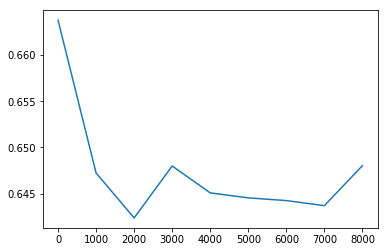

In [10]:
print(model_name)
plt.plot(np.linspace(0, num_iters, num_iters/step_size+1), dices)
# plt.ylim(0.65, 0.67)

mi_t2g_b32l5s05


/afs/csail.mit.edu/u/c/courtney/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


(0.65, 0.67)

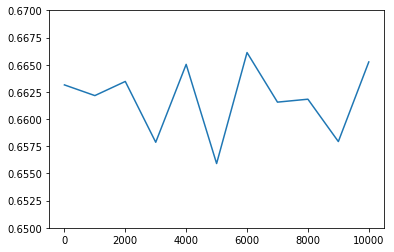

In [11]:
print(model_name)
plt.plot(np.linspace(0, num_iters, num_iters/step_size+1), dices)
plt.ylim(0.65, 0.67)

/afs/csail.mit.edu/u/c/courtney/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0,0.5,'MI')

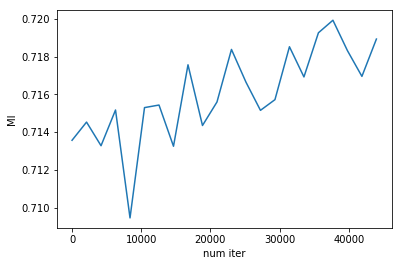

In [9]:
file = open('../models/mi_b45l5/mi_b45l5.txt','rb') 
dices, mis = pickle.load(file)
plt.plot(np.linspace(0, 44000, 44000/2000), mis)
plt.xlabel('num iter')
plt.ylabel('MI')

/afs/csail.mit.edu/u/c/courtney/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  """Entry point for launching an IPython kernel.


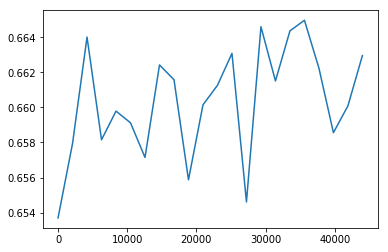

In [8]:
plt.plot(np.linspace(0, 44000, 44000/2000), dices)


/afs/csail.mit.edu/u/c/courtney/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  """Entry point for launching an IPython kernel.


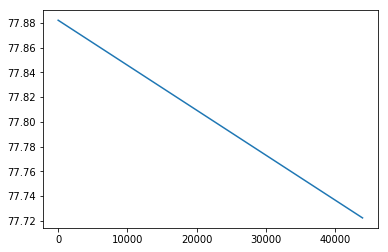

In [9]:
plt.plot(np.linspace(0, 44000, 44000/40000+1), mis)
# plt.ylim(0.65, 0.67)

/afs/csail.mit.edu/u/c/courtney/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  """Entry point for launching an IPython kernel.


(0.65, 0.67)

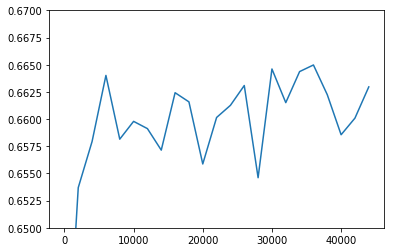

In [8]:
plt.plot(np.linspace(0, 44000, 44000/2000+1), dices)
plt.ylim(0.65, 0.67)

/afs/csail.mit.edu/u/c/courtney/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  """Entry point for launching an IPython kernel.


(0.65, 0.67)

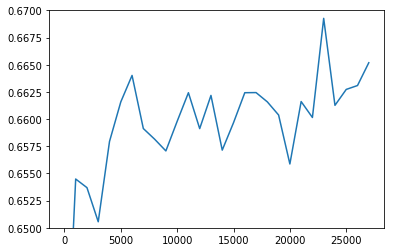

In [20]:
plt.plot(np.linspace(0, 27000, 27000/1000+1), dices)
plt.ylim(0.65, 0.67)

/afs/csail.mit.edu/u/c/courtney/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  """Entry point for launching an IPython kernel.


(0.72, 0.75)

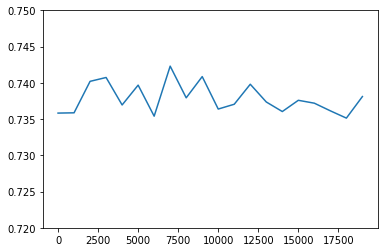

In [7]:
plt.plot(np.linspace(0, 19000, 19000/1000+1), dices)
plt.ylim(0.72, 0.75)

(0.68, 0.72)

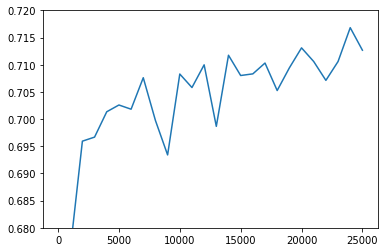

In [20]:
plt.plot(np.linspace(0, 25000, 26), dices)
plt.ylim(0.68, 0.72)

(0.68, 0.7)

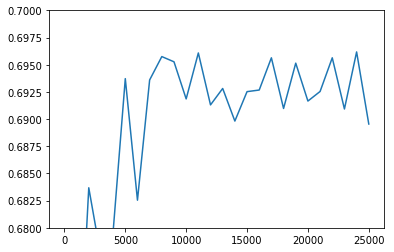

In [19]:
plt.plot(np.linspace(0, 25000, 26), dices)
plt.ylim(0.68, 0.7)

In [21]:
%%time
dices = []
step_size = 5000
for i in range(25000//step_size + 1):
    print(i)
    dices.append(test(model_name, i*step_size, gpu_id, 10, True, 0.7))

0
1
2
3
4
5
CPU times: user 8min 49s, sys: 1min 10s, total: 10min
Wall time: 6min 28s


In [28]:
%%time
dices_2 = []
step_size = 5000
for i in range(iter_num//step_size + 1):
    print(i)
    dices_2.append(test(model_name, i*step_size, gpu_id, 10, False, 0.7))

0
1
2
3
4
5
6
7
8
CPU times: user 13min 28s, sys: 2min 13s, total: 15min 41s
Wall time: 10min 17s


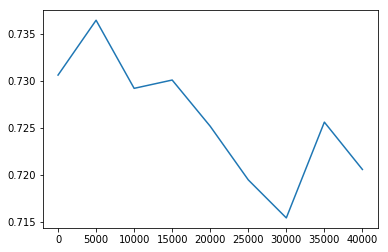

In [30]:
plt.plot([i*step_size for i in range(iter_num//step_size + 1)], dices_2)

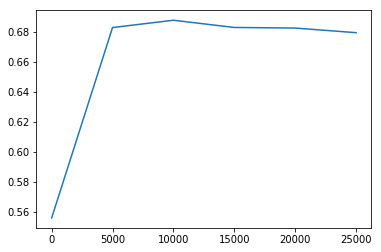

In [31]:
plt.plot([i*step_size for i in range(25000//step_size + 1)], dices)